# Order Service Example

This notebook will demonstrate how to submit a request to the Hydrosat Fusion Hub Order Service and load the data. 

In [1]:
import json
import requests

import os
import base64
from pystac_client import Client
import time
import urllib
import pandas as pd

This next cell opens a file creds.json which you will need to create in the same directory as the notebook. The format of the file should be:

```
{
"username":"your_username",
"password":"your_password"
}
```

In [2]:
with open('creds.json') as f:
    creds = json.loads(f.read())

and you have updated with your username and password. The next cells extract your credentials to pass to the order service endpoint.

In [3]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com/'
catalog = Client.open(cat_url, headers)

Let's grab some items that will reflect parameters for a request to the order service so we can grab the appropriate coordinate reference system to pass to the order service payload.

In [4]:
bbox = [-120.0373077392578, 36.16836821871061, -119.99130249023436, 36.19109202182454]
start_date ="2021-08-07T00:00:00Z"
end_date = "2021-08-17T23:59:59Z"    
collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat_hires" ]

search = catalog.search(
    collections = collections,
    bbox = bbox,
    datetime = [start_date, end_date],
    max_items = 500
)

items = list(search.items())
print(f"number of items returned: {len(items)}")

number of items returned: 10


In [5]:
# check the coordinate system for one of the items:
epsg = items[0].to_dict()['assets']['lst']['proj:epsg']
print(epsg)

32610


We will use the CRS printed out above, as well as the `start_date`, `end_date`, `bbox`, and the geometry information from the `bbox`, to create a payload which needs to be passed the order service endpoint. Change the `start_date`, `end_date`, `projection`, and `assets` to match what is needed for the order. Please visit our [documentation page](https://hydrosat.github.io/fusion-hub-docs/3-FH-API-Spec.html#orders-service) for additional information on the order service.

Note \#1: for the order service, start date needs to be formatted as "YYYY-MM-DD", so we will use string formatting to extract that information from the format we passed to the STAC API.

Note \#2: To get the geometry coordinates from the `bbox` list of coordinates, we will use shapely to convert that list to a polygon and get the coordinates from the polygon boundary. We will use that polygon to see where on the map we are, too.

In [6]:
from shapely.geometry import shape, box
import geopandas as gpd
import folium 
from pyproj.crs import CRS

In [7]:
polygon = box(*bbox)
coords = list(polygon.boundary.coords)

In [8]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
df = gpd.GeoDataFrame({'geometry': [polygon]}, crs=CRS(4326))

p_geom = polygon.centroid
m = folium.Map(location=[p_geom.y, p_geom.x], zoom_start=13, tiles='CartoDB positron')

# add the polygon and centroid
for _, r in df.iterrows():
    # Without simplifying the representation of each polygon,
    # the map might not be displayed
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    sim_geo = r[0].simplify(tolerance=0.001)
    geo_j = gpd.GeoSeries(sim_geo).to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    
    geo_j.add_to(m)
    
    lat = sim_geo.centroid.y
    lon = sim_geo.centroid.x
    folium.Marker(location=[lat, lon]).add_to(m)
    
m

now we construct the payload as described

In [9]:
payload = {
    "start_date": start_date.split('T')[0],
    "end_date": end_date.split('T')[0],
    "projection": f"epsg:{epsg}",
    "resolution": 20.0,
    "output_format": "GeoTIFF",
    "collections": collections,
    "assets": [
      "lst",
      "combined_qa"
    ],
    "bbox": bbox,
    "geometry": {
      "type": "Polygon",
      "coordinates": [coords]
    }
}

In [10]:
order_url = 'https://fusion-stac.hydrosat.com/orders'

p = requests.post(order_url, headers=headers, json=payload)

In [11]:
p.json()

{'orderId': 'bb450c0c-fe93-4de0-8581-e651ad4b656b',
 'url': 'https://fusion-stac.hydrosat.com/orders/bb450c0c-fe93-4de0-8581-e651ad4b656b'}

sometimes the order service takes a bit to start, so we will check for a status code of `500` and once the order service begins processing, the status will change to `pending`. Once it is finished, we will download the data to a local folder called 'my_order' (change it to whatever is appropriate). 

In the order payload, we specified the `combined_qa` asset to be ordered in addition to `lst`. This example only downloads the `lst` asset for each item. To download the `combined_qa` asset, swap out 'lst' for 'combined_qa' in the `assemble the assets and urls` section of the code in this block.

In [12]:
# ping the order status until it completes
while (requests.get(p.json()['url'], headers=headers).status_code == 500) or (requests.get(p.json()['url'], headers=headers).json()['status'] == 'pending'):
    time.sleep(15)
    pass

# get the compeleted order service response, which will contain URLs for the items to download
g = requests.get(p.json()['url'], headers=headers)
res = g.json()

# specify a folder to hold the data
local_folder = 'my_order'

# create it if it does not exist
if not os.path.exists(local_folder):
    os.makedirs(local_folder)
    
# assemble the assets and urls
dl_assets = [r['assets']['lst']['href'] for r in res['output']['features']]
dl_urls =[d.split('?')[0] for d in dl_assets]

# illegal character set to check against
sets = [':','*','?','"','<','>','|']

# for each of the items, download it to the folder.
for dl_url, dl_asset in zip(dl_urls, dl_assets):
    if local_folder is not None:
        outfile = os.path.join(local_folder, os.path.basename(dl_url)) #+ '.tif')
        for char in outfile:
            if char in sets:
                outfile = outfile.replace(char,'_')
    else:
        outfile = os.path.basename(dl_url) #+ '.tif'
        for char in outfile:
            if char in sets:
                outfile = outfile.replace(char,'_')

    # download file if it doesn't exist. If you wish to overwrite, comment this if-else statement and uncomment the
    # line below it.
    if not os.path.exists(outfile):
        urllib.request.urlretrieve(dl_asset, outfile)
    else:
        pass
    
    #urllib.request.urlretrieve(dl_asset, outfile)

Once the data is downloaded, we can load it as a data cube using `rioxarray`. The dataset will not be time-aware immediately, so we will assign the time dimension of each file using information from the filename.

In [13]:
import rioxarray as rxr
import xarray as xr
from glob import glob

In [14]:
all_tifs = glob(f"{local_folder}/*.tif")
order_ds = xr.concat([rxr.open_rasterio(t) for t in all_tifs], dim='time')

# print out the shape of the data retrieved from the order
order_ds.shape

(10, 1, 134, 212)

In [15]:
# assign values to the time dimension
date_strings = [os.path.basename(t).split('_')[0] for t in all_tifs]
datetimes = pd.to_datetime(date_strings, infer_datetime_format=True, utc=True) #more general conversion
datetimes_formatted = [d.to_pydatetime() for d in datetimes]

order_ds = order_ds.assign_coords(time=('time', datetimes_formatted))
order_ds

<xarray.DataArray (time: 10, band: 1, y: 134, x: 212)>
array([[[[324.78488, 324.17386, 324.42136, ..., 327.54105, 327.54724,
          327.2811 ],
         [323.59692, 324.40796, 324.10474, ..., 327.54163, 327.5912 ,
          327.1827 ],
         [323.4645 , 323.38083, 323.75497, ..., 327.57086, 327.57855,
          327.38715],
         ...,
         [316.41718, 316.00473, 315.78592, ..., 328.6174 , 328.55954,
          327.36133],
         [316.79315, 316.57495, 315.6735 , ..., 327.88553, 327.2523 ,
          326.57767],
         [316.48755, 316.1326 , 315.72632, ..., 328.22552, 328.1523 ,
          326.67685]]],


       [[[324.55463, 323.88956, 324.14334, ..., 325.67297, 325.73233,
          325.42755],
         [323.31625, 324.0231 , 323.76718, ..., 325.46542, 325.4459 ,
          325.32523],
         [323.17383, 323.11612, 323.46878, ..., 325.27615, 325.35345,
...
          336.94434],
         [324.62704, 324.02908, 324.03397, ..., 336.4555 , 336.30942,
          335.70493],
         [324.70685, 324.10892, 324.05777, ..., 334.92535, 335.62366,
          334.9967 ]]],


       [[[335.546  , 335.87915, 335.48364, ..., 339.02084, 339.5565 ,
          339.6035 ],
         [334.51392, 335.04837, 335.03357, ..., 339.9033 , 339.60672,
          338.81256],
         [334.55142, 334.80133, 334.72388, ..., 339.84744, 339.79135,
          339.97314],
         ...,
         [326.04852, 325.83063, 325.5753 , ..., 338.84134, 338.91254,
          337.87   ],
         [326.65375, 325.85977, 325.8453 , ..., 337.46426, 337.30167,
          336.66757],
         [326.75595, 325.98505, 325.88034, ..., 336.03467, 336.666  ,
          336.01385]]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 7.664e+05 7.664e+05 ... 7.706e+05 7.706e+05
  * y            (y) float64 4.009e+06 4.009e+06 ... 4.007e+06 4.007e+06
    spatial_ref  int32 0
  * time         (time) object 2021-08-07T00:00:00+00:00 ... 2021-08-17T00:00...
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

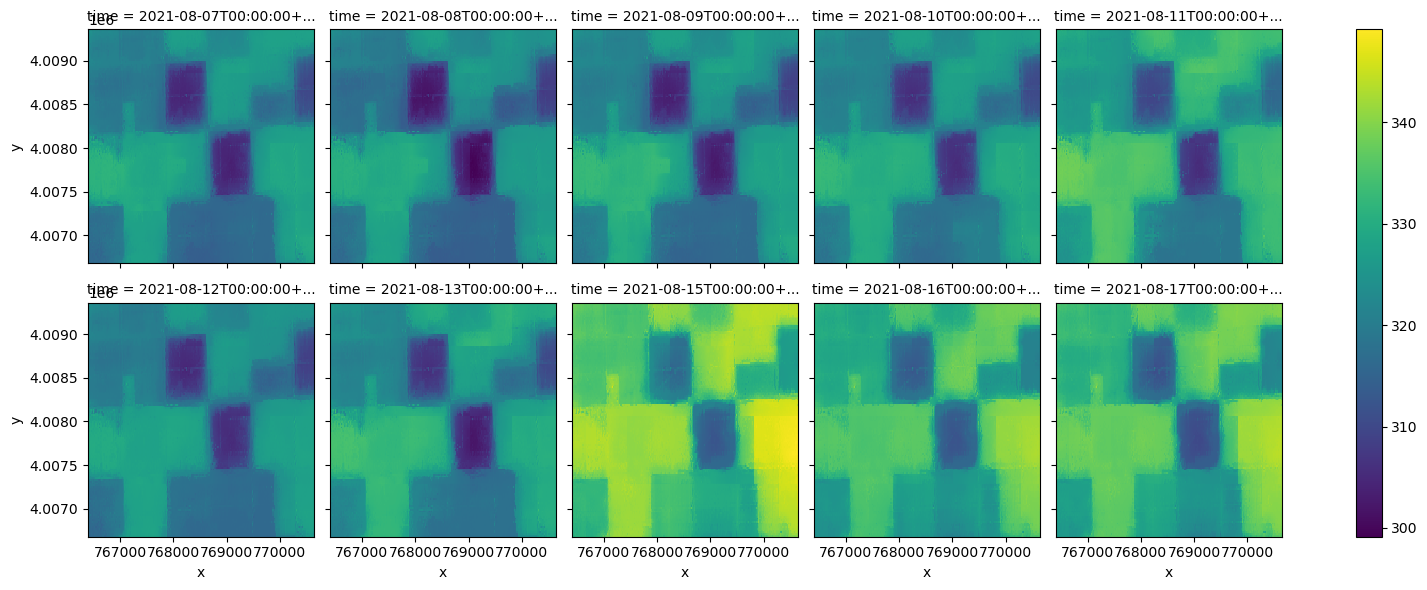

In [16]:
# now lets plot them. If your order is large, you will want to subset the time dimension
# by calling order_ds.isel(time=[0,1,2,3])... see xarray documentation for more use of selecting data
order_ds.plot(x='x', y='y', col='time', col_wrap=5)